In [1]:
import pandas as pd
from os.path import join
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

%matplotlib inline

In [31]:
tpm_shoal_fmt = join("/fs/cbcb-lab/rob/students/noor/shoal_proj/seqc/shoal_gene", "vbprior=1e0", "{fname}", "{fold}", "{sample}_c={w}_gene_quant.sf")
tpm_sal_fmt = join("/fs/cbcb-lab/rob/students/noor/shoal_proj/seqc/sal_gene", "BGI_FC1_{cond}_{rep}", "vbprior=1e0", "{fold}", "gene_quant.sf")

SAMPLES = [
    'BGI_FC1_A_1',
    'BGI_FC1_A_2',
    'BGI_FC1_A_3',
    'BGI_FC1_A_4',
    'BGI_FC1_B_1',
    'BGI_FC1_B_2',
    'BGI_FC1_B_3',
    'BGI_FC1_B_4',
    'BGI_FC1_C_1',
    'BGI_FC1_C_2',
    'BGI_FC1_C_3',
    'BGI_FC1_C_4']
#     'BGI_FC1_D_1',
#     'BGI_FC1_D_2',
#     'BGI_FC1_D_3',
#     'BGI_FC1_D_4' ]
best_weights = [1000, 1000, 100, 100, 100, 100, 10, 100, 1000, 1000, 100, 100]
fnames = ["A_B"]*12
fnames[8:12] = ["C"]*4

CONDS = ['A', 'B', 'C']
REPLICATES = [1, 2, 3, 4]


In [4]:
taqman_fp ='/fs/cbcb-lab/rob/students/jason/perplexity-paper/seqc/data/seqc_taqman_data.tsv'
taqman_df = pd.read_csv(taqman_fp, sep='\t')
taqman_df.head()

,EntrezID,Symbol,A1_value,A2_value,A3_value,A4_value,B1_value,B2_value,B3_value,B4_value,C1_value,C2_value,C3_value,C4_value,D1_value,D2_value,D3_value,D4_value,ensembl_gene_id,hgnc_symbol
0,10,NAT2,0.000506,0.000506,0.000506,0.000506,0.000480,0.000480,0.000497,0.000480,0.000321,0.000507,0.000321,0.000321,0.000386,0.000619,0.000663,0.000501,ENSG00000156006,NAT2
1,100,ADA,2.228907,2.259929,2.236086,2.295411,0.094705,0.104981,0.094734,0.096268,1.613193,1.608827,1.632794,1.561465,0.721803,0.728882,0.717217,0.728945,ENSG00000196839,ADA
2,10024,TROAP,0.530779,0.580131,0.523694,0.529267,0.000678,0.000819,0.000444,0.001405,0.368423,0.349775,0.379056,0.356175,0.148059,0.146182,0.143067,0.149874,ENSG00000135451,TROAP
3,10057,ABCC5,0.034760,0.040591,0.037755,0.034695,0.123607,0.145910,0.134618,0.142582,0.070593,0.068641,0.070013,0.074457,0.053343,0.059714,0.055769,0.060391,ENSG00000114770,ABCC5
4,10058,ABCB6,0.866165,0.925812,0.946031,0.972846,0.572150,0.542244,0.597979,0.568880,0.918142,0.911282,0.957890,0.920416,0.598474,0.629172,0.616281,0.581824,ENSG00000115657,ABCB6


In [5]:
len(set(taqman_df['ensembl_gene_id']))

897

In [6]:
len(set(taqman_df['EntrezID']))

896

In [7]:
del taqman_df['EntrezID']
del taqman_df['Symbol']

In [8]:
taqman_df = taqman_df.groupby('ensembl_gene_id').mean().reset_index()

In [9]:
taqman_df = taqman_df.sort_values(by='ensembl_gene_id').set_index('ensembl_gene_id')

In [10]:
taqman_df

,A1_value,A2_value,A3_value,A4_value,B1_value,B2_value,B3_value,B4_value,C1_value,C2_value,C3_value,C4_value,D1_value,D2_value,D3_value,D4_value
ensembl_gene_id,,,,,,,,,,,,,,,,
ENSG00000000938,0.001404,0.000861,0.000679,0.000746,0.037568,0.006281,0.040852,0.039461,0.008521,0.010289,0.009923,0.010823,0.029000,0.031594,0.031336,0.032728
ENSG00000002016,0.071401,0.073062,0.067908,0.074465,0.068388,0.071034,0.073211,0.074430,0.078207,0.080860,0.076703,0.080300,0.070045,0.074698,0.076039,0.069439
ENSG00000002587,0.014171,0.013352,0.013168,0.013413,0.215992,0.218947,0.223947,0.213962,0.048661,0.048708,0.050617,0.053383,0.132898,0.139889,0.140541,0.149312
ENSG00000002933,0.010067,0.008611,0.008341,0.006556,0.270932,0.277275,0.298070,0.298121,0.067744,0.065518,0.067520,0.073828,0.185877,0.183786,0.187345,0.180342
ENSG00000003402,0.255988,0.257778,0.262256,0.258482,0.437681,0.446478,0.456057,0.449460,0.266897,0.276109,0.263746,0.268335,0.377925,0.374105,0.377121,0.375165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000259494,0.352620,0.357890,0.352128,0.352537,0.297559,0.305728,0.309209,0.298047,0.317804,0.319213,0.317936,0.314950,0.289414,0.291229,0.280562,0.270936
ENSG00000260027,0.135622,0.147856,0.140924,0.147866,0.001357,0.000858,0.001233,0.001228,0.101237,0.104532,0.105082,0.103727,0.039606,0.038412,0.038703,0.039073
ENSG00000261609,0.181016,0.171455,0.183419,0.174220,0.329759,0.347811,0.349810,0.342059,0.224269,0.229523,0.224660,0.228420,0.269678,0.272963,0.274439,0.268899


In [11]:
taqman_df=taqman_df.drop(axis=1, columns=["D1_value", "D2_value", "D3_value", "D4_value"])

In [35]:
taqman_genes = set(taqman_df.index)
#tpm_shoal_fmt = join("/fs/cbcb-lab/rob/students/noor/shoal_proj/seqc/shoal_gene", "vbprior=1e0", "{fname}", "{fold}", "{cond}_{rep}_c={w}_gene_quant.sf")
quant_fp = '../seqc/output/seqc-bgi/gene_quants/BGI_FC1_{cond}_{rep}/vbprior={vb_prior}/{fold}/gene_quant.sf'
def strip_ensembl_ver(name):
    return name.split('.')[0]

def quant_data_sal(fold):
    all_df = pd.DataFrame()
    for cond in CONDS:
        for rep in range(1,5):
            df = pd.read_csv(tpm_sal_fmt.format(cond=cond, rep=rep, fold=fold), sep='\t',
                            index_col=None, usecols=['abundance']).reset_index()
            df['index'] = df['index'].apply(strip_ensembl_ver)
            df = df[df['index'].isin(taqman_genes)]
            all_df['index'] = df['index']
            all_df['{}{}'.format(cond, rep)] =  df['abundance']
    all_df = all_df.sort_values(by='index').set_index('index')
    return all_df

def quant_data_shoal(fold):
    j=0
    all_df = pd.DataFrame()
    for cond in CONDS:
        for rep in range(1,5):
            #print(tpm_shoal_fmt.format(fname=fnames[j], sample=SAMPLES[j], w=best_weights[j], fold=fold))
            df = pd.read_csv(tpm_shoal_fmt.format(fname=fnames[j], sample=SAMPLES[j], w=best_weights[j], fold=fold), sep='\t',
                            index_col=None, usecols=['abundance']).reset_index()
            df['index'] = df['index'].apply(strip_ensembl_ver)
            df = df[df['index'].isin(taqman_genes)]
            all_df['index'] = df['index']
            all_df['{}{}'.format(cond, rep)] =  df['abundance']
            j=j+1
    all_df = all_df.sort_values(by='index').set_index('index')
    return all_df


In [36]:
df=quant_data_shoal(1)
df

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,C3,C4
index,,,,,,,,,,,,
ENSG00000000938,0.085937,0.201248,0.086362,0.053848,2.883728,4.728296,3.613034,4.331843,0.921017,0.664671,0.536976,0.585392
ENSG00000002016,14.390146,12.959285,14.074481,15.758949,13.317910,14.169744,17.362043,13.400093,13.905635,16.002559,12.379668,11.832834
ENSG00000002587,0.416205,0.176953,0.405637,0.266167,10.046853,5.557257,6.337512,5.436491,1.395092,1.372126,1.420367,1.178357
ENSG00000002933,0.436649,0.441077,0.236338,0.447727,17.331467,16.203763,15.918353,16.847786,3.740182,3.217188,3.864739,3.679341
ENSG00000003402,30.117372,30.183263,29.722640,33.594597,34.649881,34.167021,35.400250,36.240766,33.568820,34.038947,32.561014,30.817325
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000259494,34.496445,35.722051,35.129638,34.689099,24.768512,23.233283,22.334248,26.582831,33.808348,34.446396,30.819144,32.374758
ENSG00000260027,13.636276,12.881955,14.026885,14.376348,0.325849,0.037060,0.105518,0.233302,11.676297,11.571272,11.220912,11.894188
ENSG00000261609,2.741610,2.832293,3.066607,2.957588,3.196636,3.320658,3.185275,3.098531,2.657155,3.004235,3.644510,2.841306


In [34]:
taqman_df.shape


(897, 12)

In [38]:
def arr_spearman(A, B):
    return spearmanr(A, B).correlation

def spearman_corrs(df1, df2):
    assert(df1.values.shape == df2.values.shape)
    
    spearmans = [arr_spearman(df1.values[:, i], df2.values[:, i]) for i in range(df1.shape[1])]
    return spearmans

def calc_spearman_corrs(taqman_df, meth):
    df = pd.DataFrame()
    for fold in range(1, 6):
        if meth=="salmon":
            quants = quant_data_sal(fold)
        else:
            quants = quant_data_shoal(fold)

        spearmans = spearman_corrs(taqman_df, quants)
        N = len(spearmans)
        df = df.append(pd.DataFrame(dict(Spearman_r=spearmans, 
                       method=meth,
                       fold=[fold] *N,
                       cond=['A']*4 + ['B'] * 4 + ['C'] * 4)), ignore_index=True)
                       #cond=['A']*4 + ['B'] * 4 + ['C'] * 4 + ['D'] * 4)), ignore_index=True)
    return df
            
    


In [40]:
spearman_df = calc_spearman_corrs(taqman_df, "salmon")
spearman_df

,Spearman_r,method,fold,cond
0,0.846580,salmon,1,A
1,0.841144,salmon,1,A
2,0.848315,salmon,1,A
3,0.848189,salmon,1,A
4,0.843283,salmon,1,B
5,0.845808,salmon,1,B
6,0.847702,salmon,1,B
7,0.845578,salmon,1,B
8,0.817444,salmon,1,C
9,0.818383,salmon,1,C


In [42]:
spearman_df=spearman_df.append(calc_spearman_corrs(taqman_df, "shoal"))

In [ ]:
spearman_df.vb_prior = spearman_df.vb_prior.astype(float)

In [ ]:
# ax = sns.violinplot(x="vb_prior", y="Spearman_r", data=spearman_df, inner=None, hue="cond")
# ax = sns.swarmplot(x="vb_prior", y="Spearman_r", data=spearman_df,
#                    color="white", edgecolor="gray", dodge=True, s=1, hue="cond")
# ax.set_title('SEQC Spearman Corr. vs. Microarray')

In [43]:
mean_fold_df = spearman_df.groupby(['cond', 'method', 'fold']).mean().reset_index()

In [44]:
mean_fold_df

,cond,method,fold,Spearman_r
0,A,salmon,1,0.846057
1,A,salmon,2,0.845855
2,A,salmon,3,0.845559
3,A,salmon,4,0.845819
4,A,salmon,5,0.845897
5,A,shoal,1,0.847605
6,A,shoal,2,0.847246
7,A,shoal,3,0.847039
8,A,shoal,4,0.847419
9,A,shoal,5,0.847386


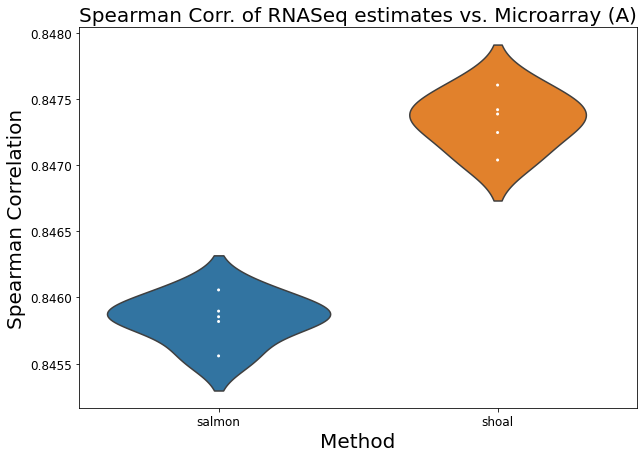

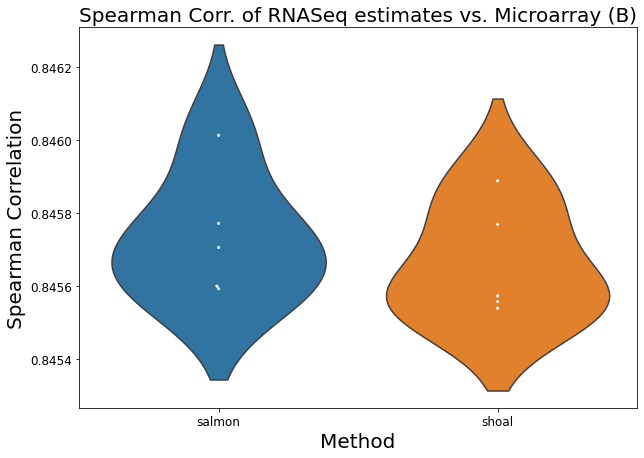

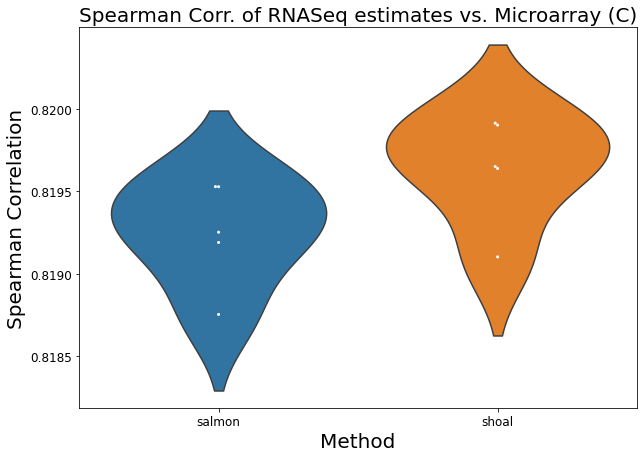

In [46]:
for cond in CONDS:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#     ax.ticklabel_format(axis='x', style='sci', sci)
    ax = sns.violinplot(x="method", y="Spearman_r", data=mean_fold_df[mean_fold_df.cond == cond], inner=None, ax=ax)
    ax = sns.swarmplot(x="method", y="Spearman_r", data=mean_fold_df[mean_fold_df.cond == cond],
                       color="white", edgecolor="gray", dodge=True, s=3, ax=ax)
    ax.set_title('Spearman Corr. of RNASeq estimates vs. Microarray ({})'.format(cond), fontsize=20)
        
    ax.set_ylabel('Spearman Correlation', fontsize=20)
    ax.set_xlabel('Method', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.show()
    

In [ ]:
mean_df = spearman_df.groupby(['cond', 'method']).mean().reset_index()

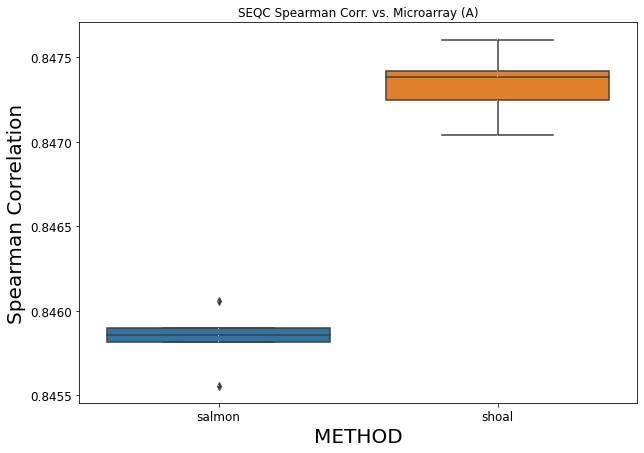

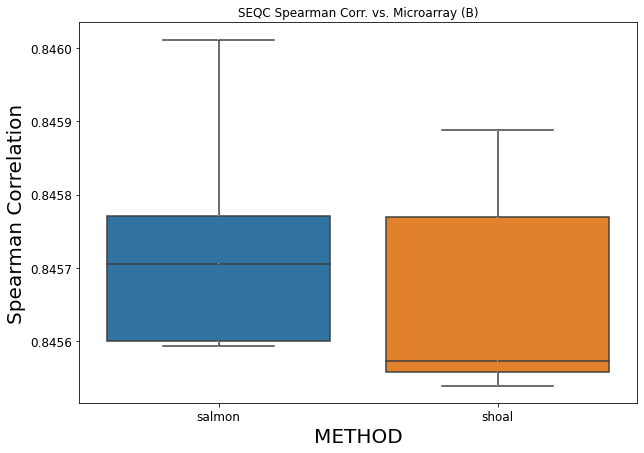

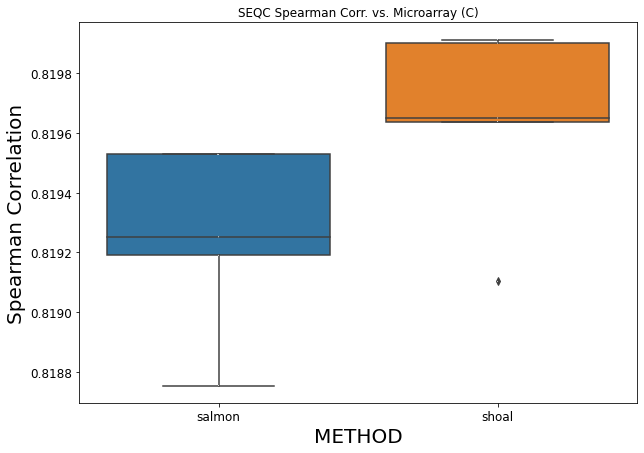

In [48]:
for cond in CONDS:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax = sns.boxplot(x="method", y="Spearman_r", data=mean_fold_df[mean_fold_df.cond == cond])
    ax = sns.swarmplot(x="method", y="Spearman_r", data=mean_fold_df[mean_fold_df.cond == cond],
                       color="white", edgecolor="gray", dodge=True, s=1)
    ax.set_title('SEQC Spearman Corr. vs. Microarray ({})'.format(cond))
    ax.set_ylabel('Spearman Correlation', fontsize=20)
    ax.set_xlabel('METHOD', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()